# DRAFT

DATASET - https://www.kaggle.com/datasets/rabieelkharoua/chronic-kidney-disease-dataset-analysis

In [82]:
# Импорт необходимых библиотек для анализа данных, визуализации, и машинного обучения
import pandas as pd
import numpy as np
import missingno

# визуализация данных
import seaborn as sns
import matplotlib.pyplot as plt

# машинное обучение
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, average_precision_score, precision_recall_curve
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from scipy import stats

In [83]:
# Загрузка исходных данных из файла CSV
# Отображение первых строк для общего представления о структуре данных
df = pd.read_csv('data/Chronic_Kidney_Dsease_data.csv')
df.head()

,PatientID,Age,Gender,Ethnicity,SocioeconomicStatus,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,...,Itching,QualityOfLifeScore,HeavyMetalsExposure,OccupationalExposureChemicals,WaterQuality,MedicalCheckupsFrequency,MedicationAdherence,HealthLiteracy,Diagnosis,DoctorInCharge
0,1,71,0,0,0,2,31.069414,1,5.128112,1.676220,...,7.556302,76.076800,0,0,1,1.018824,4.966808,9.871449,1,Confidential
1,2,34,0,0,1,3,29.692119,1,18.609552,8.377574,...,6.836766,40.128498,0,0,0,3.923538,8.189275,7.161765,1,Confidential
2,3,80,1,1,0,1,37.394822,1,11.882429,9.607401,...,2.144722,92.872842,0,1,1,1.429906,7.624028,7.354632,1,Confidential
3,4,40,0,2,0,1,31.329680,0,16.020165,0.408871,...,7.077188,90.080321,0,0,0,3.226416,3.282688,6.629587,1,Confidential
4,5,43,0,1,1,2,23.726311,0,7.944146,0.780319,...,3.553118,5.258372,0,0,1,0.285466,3.849498,1.437385,1,Confidential


In [84]:
# Проверка структуры данных: типы данных, количество ненулевых значений в каждом столбце
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1659 entries, 0 to 1658
Data columns (total 54 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   PatientID                      1659 non-null   int64  
 1   Age                            1659 non-null   int64  
 2   Gender                         1659 non-null   int64  
 3   Ethnicity                      1659 non-null   int64  
 4   SocioeconomicStatus            1659 non-null   int64  
 5   EducationLevel                 1659 non-null   int64  
 6   BMI                            1659 non-null   float64
 7   Smoking                        1659 non-null   int64  
 8   AlcoholConsumption             1659 non-null   float64
 9   PhysicalActivity               1659 non-null   float64
 10  DietQuality                    1659 non-null   float64
 11  SleepQuality                   1659 non-null   float64
 12  FamilyHistoryKidneyDisease     1659 non-null   i

In [85]:
# Удаление неинформативных или идентификационных столбцов, не влияющих на анализ данных
df = df.drop("PatientID", axis=1)
df = df.drop("DoctorInCharge", axis=1)

In [86]:
# Разделение столбцов на числовые и категориальные переменные
# Это необходимо для применения специфических методов анализа
TARGET_COLUMN = "Diagnosis"

columns_obj = ["Gender", "Ethnicity", "SocioeconomicStatus", "EducationLevel", "FamilyHistoryKidneyDisease", "FamilyHistoryHypertension", "FamilyHistoryDiabetes", "PreviousAcuteKidneyInjury", "UrinaryTractInfections", "ACEInhibitors", "Diuretics", "Statins", "AntidiabeticMedications", "Edema", "HeavyMetalsExposure", "OccupationalExposureChemicals", "WaterQuality", "Diagnosis"]
columns_num = df.columns.drop(columns_obj)

# columns_num = df.select_dtypes(include=['number']).columns
# columns_obj = df.select_dtypes(include=['object']).columns

In [87]:
# Подсчет количества дублирующихся строк в наборе данных
# Помогает выявить избыточность и улучшить качество данных
df.duplicated().sum()

0

In [88]:
# Подсчёт пропущенных значений в процентах для каждого столбца
cols_null_percent = round(df.isnull().mean() * 100, ndigits=2)
cols_with_null = cols_null_percent[cols_null_percent > 0].sort_values(ascending=False)
display(cols_with_null)

Series([], dtype: float64)

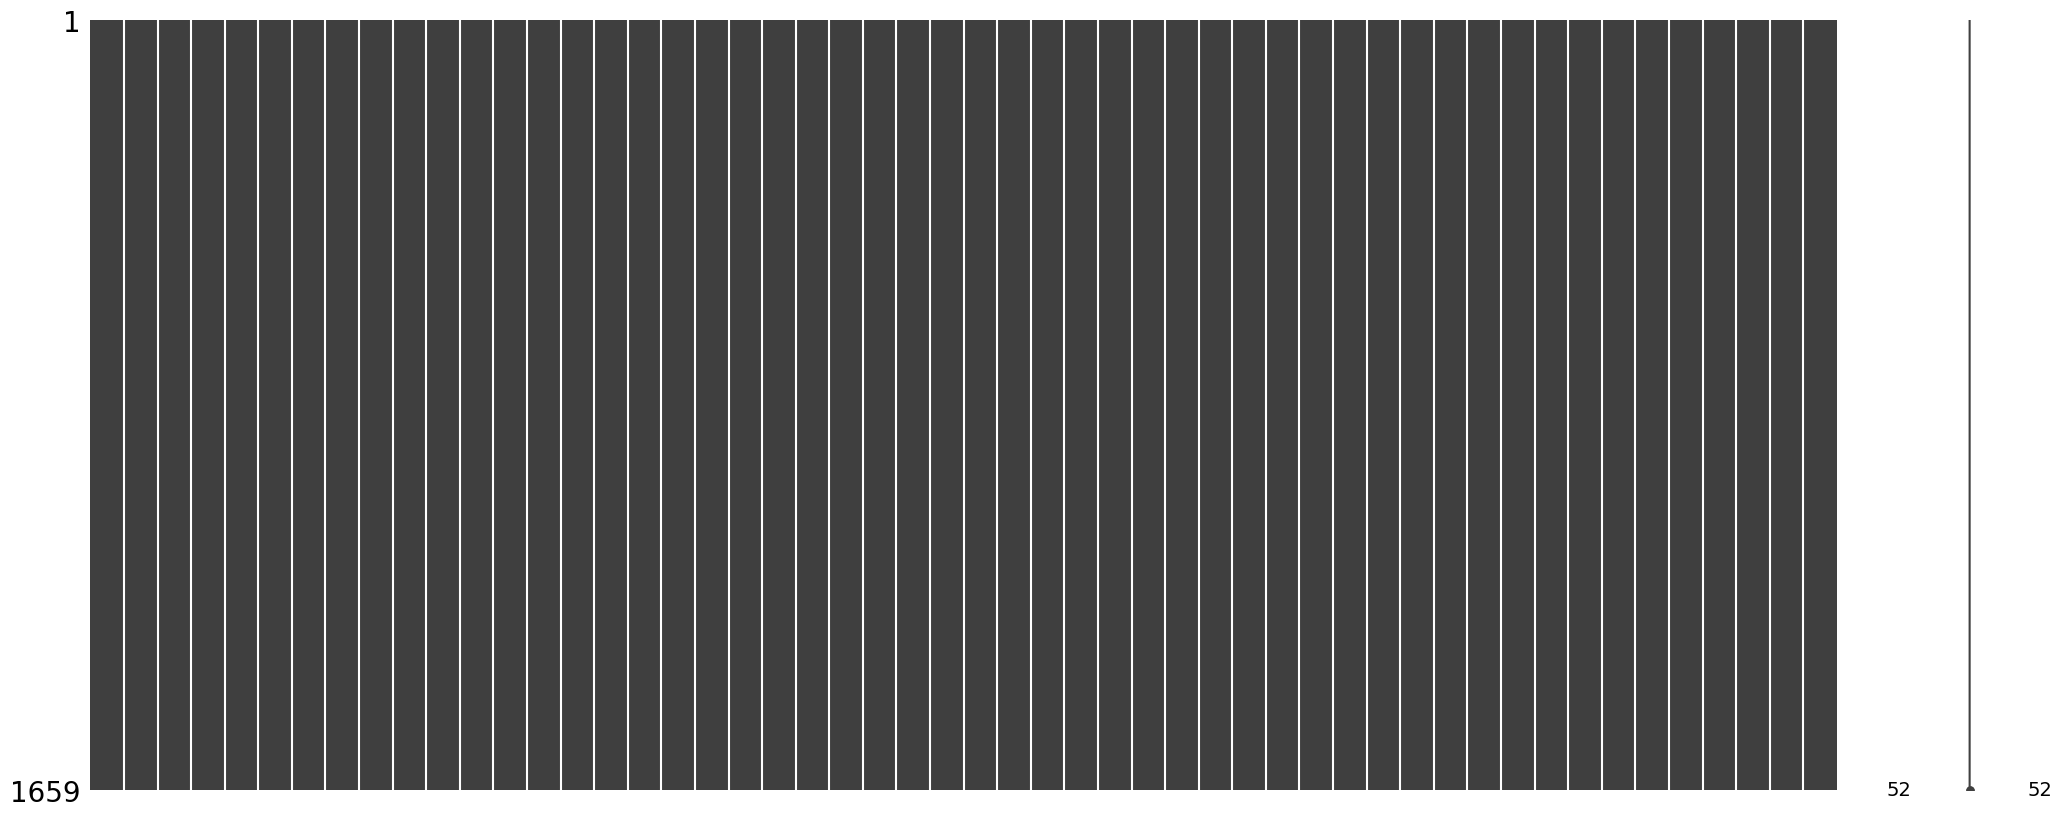

In [89]:
# Визуализация пропущенных значений для определения их распределения
missingno.matrix(df);
plt.show()

### Выводы из матрицы пропущенных значений
1. В наборе данных **отсутствуют пропущенные значения**, что подтверждается полностью заполненными вертикальными полосами на графике.
2. Данные готовы для анализа, и дополнительная обработка пропусков не требуется.

### Рекомендации
- Используйте наиболее продуктивные модели для предсказания.
- Удалите переменные с высокой корреляцией для улучшения качества модели.

In [90]:
# Статистика числовых переменных: среднее, отклонение, минимумы, максимумы. 
# Транспонируем и округляем до 2 знаков.
df[columns_num].describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
Age,1659.0,54.44,20.55,20.00,36.00,54.00,72.00,90.00
BMI,1659.0,27.62,7.29,15.03,21.47,27.65,34.02,39.99
Smoking,1659.0,0.29,0.46,0.00,0.00,0.00,1.00,1.00
AlcoholConsumption,1659.0,9.97,5.80,0.02,5.05,9.95,14.97,19.99
PhysicalActivity,1659.0,5.02,2.87,0.00,2.56,5.07,7.46,10.00
DietQuality,1659.0,5.03,2.87,0.00,2.56,4.99,7.43,10.00
SleepQuality,1659.0,6.94,1.70,4.00,5.49,6.93,8.35,9.98
SystolicBP,1659.0,134.39,25.77,90.00,113.00,134.00,157.00,179.00
DiastolicBP,1659.0,89.31,17.35,60.00,75.00,89.00,104.00,119.00
FastingBloodSugar,1659.0,132.53,36.56,70.04,100.50,131.48,163.11,199.96


In [91]:
# Статистика категориальных переменных: частоты, уникальные значения. 
# Транспонируем для удобства.
df[columns_obj].astype("object").describe().T


,count,unique,top,freq
Gender,1659,2,1,855
Ethnicity,1659,4,0,974
SocioeconomicStatus,1659,3,1,658
EducationLevel,1659,4,2,668
FamilyHistoryKidneyDisease,1659,2,0,1425
FamilyHistoryHypertension,1659,2,0,1159
FamilyHistoryDiabetes,1659,2,0,1232
PreviousAcuteKidneyInjury,1659,2,0,1484
UrinaryTractInfections,1659,2,0,1310
ACEInhibitors,1659,2,0,1169


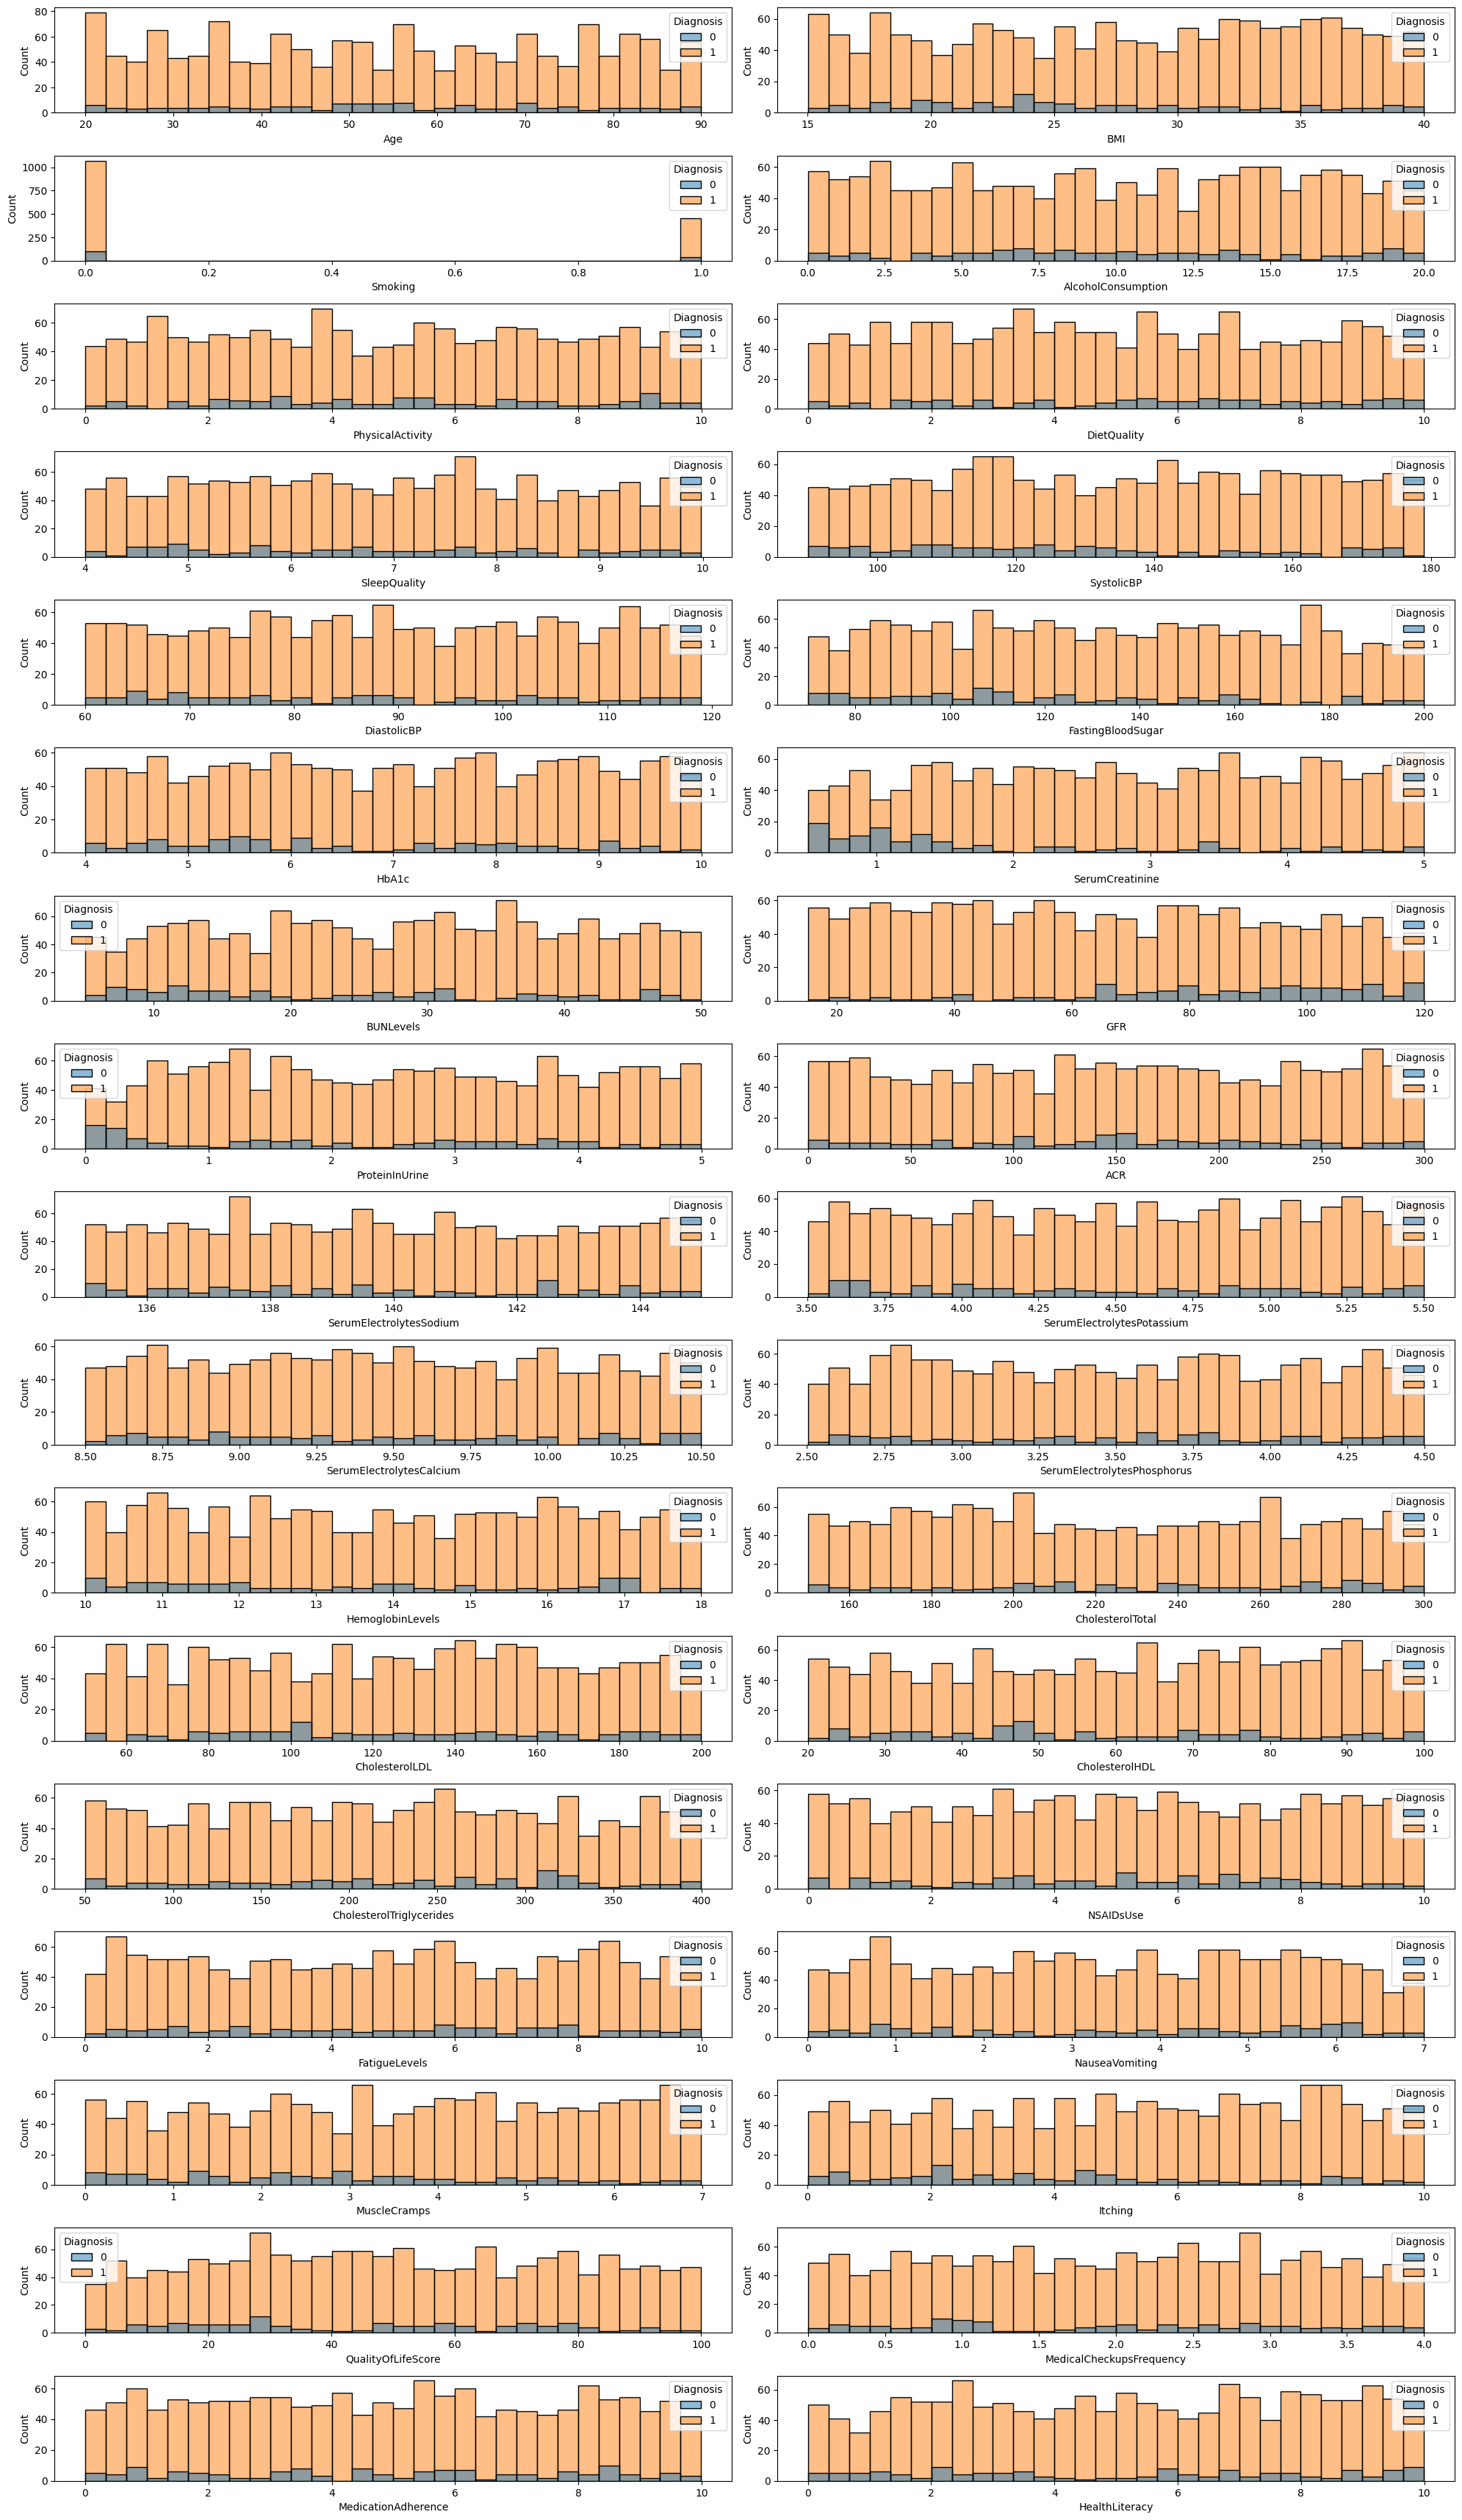

In [92]:
# Построение гистограмм числовых переменных для оценки их распределения
# Также отображает различия относительно целевой переменной
plt.figure(figsize=(20, 40), dpi=100)

for i, column in enumerate(df[columns_num], start=1):
    plt.subplot(20, 2, i)
    sns.histplot(data=df, x=column, hue=TARGET_COLUMN, bins=30)
    plt.tight_layout()

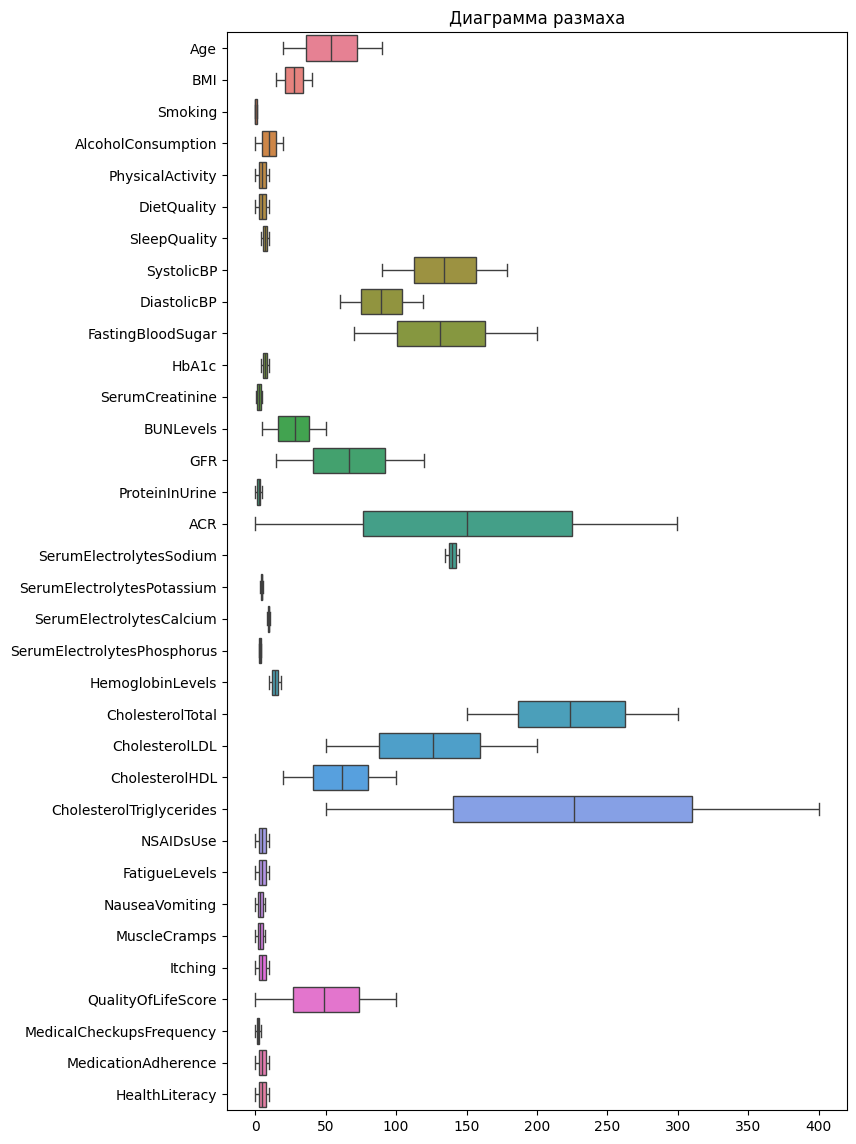

In [93]:
# Использование диаграмм размаха для выявления выбросов и анализа распределений
plt.figure(figsize=(8, 14), dpi=100)
plt.title("Диаграмма размаха")
sns.boxplot(data=df[columns_num], orient='h');

In [94]:
# Функция для построения гистограммы и диаграммы размаха в одном окне
def hist_boxplot_plot(df, column):
    fig, ax = plt.subplots(
        2,
        figsize=(14, 6),
        sharex=True,  # Общая ось X
        gridspec_kw={"height_ratios": (.7, .3)}  # Соотношение высоты графиков
    )  

    # Гистограмма
    df.hist(column=column, grid=False, bins=30, figsize=(14, 6), ax=ax[0])
    # Диаграмма размаха
    df.boxplot(column=column, grid=False, vert=False, figsize=(14, 5), ax=ax[1])
    ax[1].title.set_size(0)  # Убираем заголовок у нижнего графика
    plt.subplots_adjust(hspace=0.05)  # Уменьшаем расстояние между графиками



In [95]:
# Пустой список для записи фильтров
filter_data_masks = []

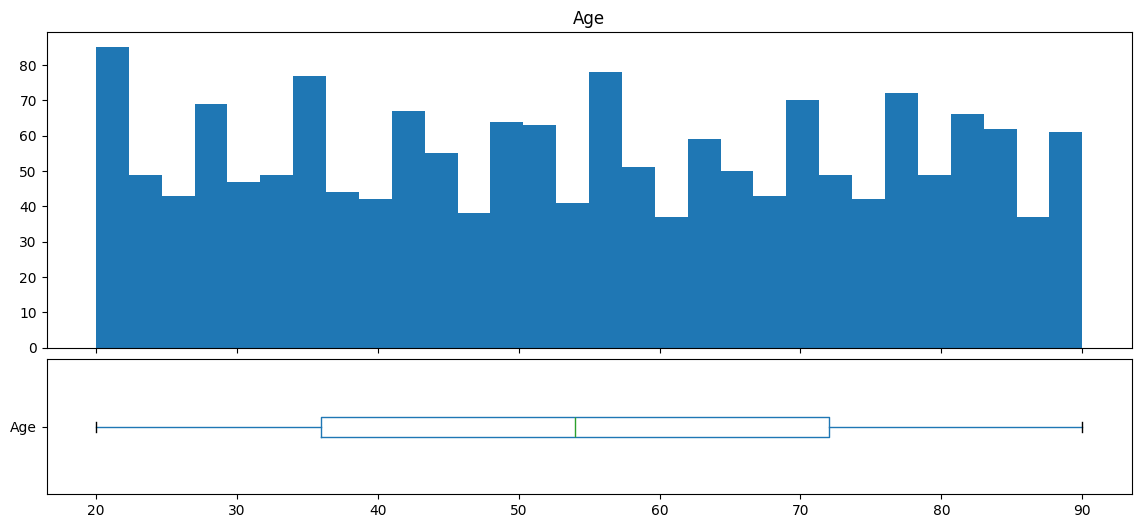

In [96]:
# Вызов функции для построения гистограммы и диаграммы размаха для столбца 'Age'
hist_boxplot_plot(df, 'Age')

In [97]:
# Перебор всех категориальных столбцов и вывод уникальных значений с их частотами
for i in columns_obj:
    if i in df.columns:
        print('All values in column {0} : \n{1}'.format(i, df[i].value_counts(dropna=False).sort_index()))
        print('\n')
    else:
        print(f'Column {i} not found in the DataFrame.')

# Отображение списка категориальных столбцов
print('Categorical columns:', columns_obj)


All values in column Gender : 
Gender
0    804
1    855
Name: count, dtype: int64


All values in column Ethnicity : 
Ethnicity
0    974
1    349
2    174
3    162
Name: count, dtype: int64


All values in column SocioeconomicStatus : 
SocioeconomicStatus
0    519
1    658
2    482
Name: count, dtype: int64


All values in column EducationLevel : 
EducationLevel
0    180
1    480
2    668
3    331
Name: count, dtype: int64


All values in column FamilyHistoryKidneyDisease : 
FamilyHistoryKidneyDisease
0    1425
1     234
Name: count, dtype: int64


All values in column FamilyHistoryHypertension : 
FamilyHistoryHypertension
0    1159
1     500
Name: count, dtype: int64


All values in column FamilyHistoryDiabetes : 
FamilyHistoryDiabetes
0    1232
1     427
Name: count, dtype: int64


All values in column PreviousAcuteKidneyInjury : 
PreviousAcuteKidneyInjury
0    1484
1     175
Name: count, dtype: int64


All values in column UrinaryTractInfections : 
UrinaryTractInfections
0    1310
1

In [98]:
# Вычисление корреляции между числовыми переменными
corrr = df[columns_num].corr()

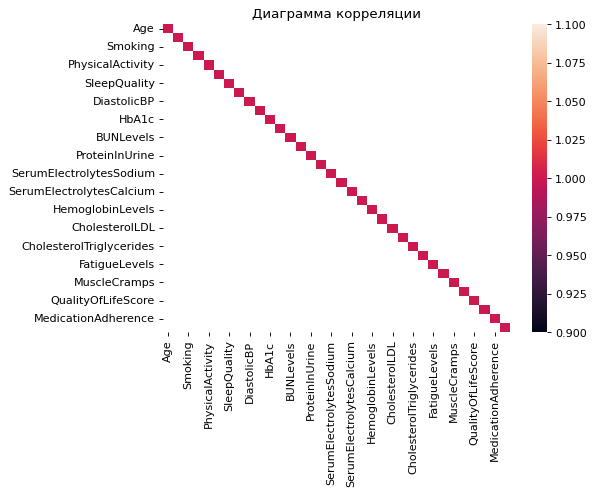

In [99]:
# Построение тепловой карты для визуализации значимых корреляций между числовыми переменными
plt.figure(figsize=(7, 5), dpi=80)
plt.title("Диаграмма корреляции")
sns.heatmap(corrr[(corrr >= 0.2) | (corrr <= -0.2)], annot=False, fmt='0.1f')
plt.show()

### Выводы из тепловой карты корреляции
1. **Низкие корреляции:**
   - Переменные имеют коэффициенты корреляции ниже 0.2 (по модулю), что указывает на слабую линейную связь между ними.
   - Это может свидетельствовать о том, что данные содержат признаки с независимой информацией, полезной для моделей машинного обучения.

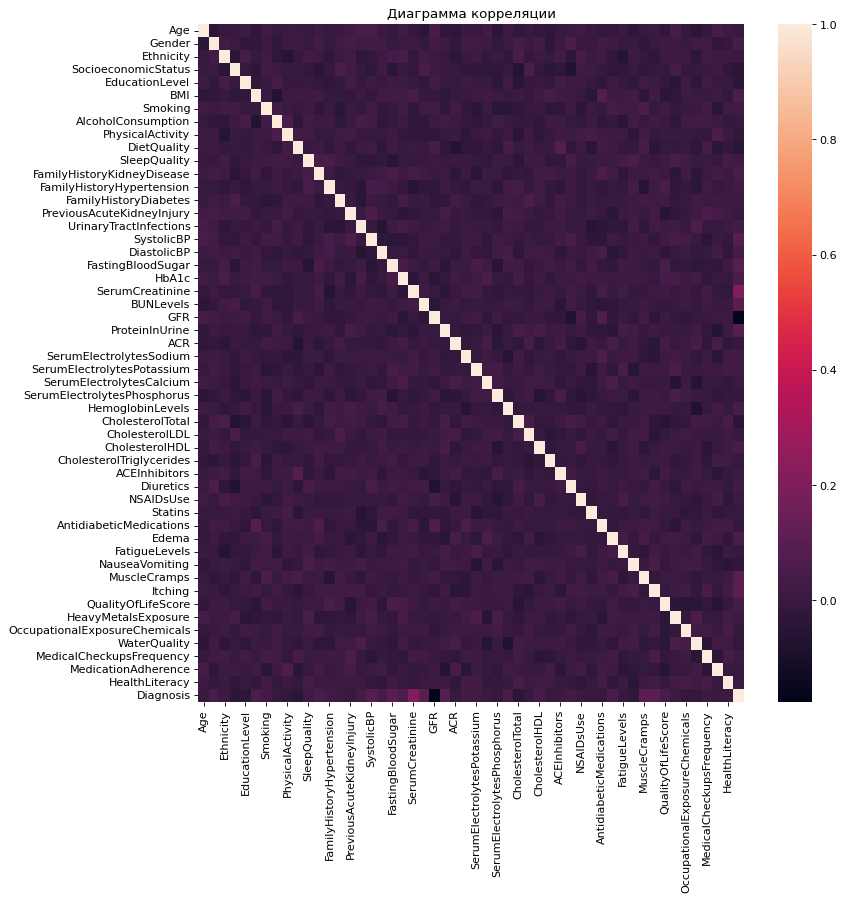

In [100]:
# Вычисление корреляции между всеми числовыми переменными
plt.figure(figsize=(11, 11), dpi=80)
plt.title("Диаграмма корреляции")
sns.heatmap(df.corr(), annot=False, fmt = '0.1f')
plt.show()

### Выводы из тепловой карты корреляции
1. **Общие наблюдения:**
   - Большинство коэффициентов корреляции между переменными лежит в диапазоне от -0.2 до 0.2, что указывает на слабую линейную связь между ними.

In [101]:
# columns_obj = df_clean.select_dtypes(include=['object']).drop(TARGET_COLUMN, axis=1)

# # перевод категориальных переменных в дамми-переменные
# df_mod = pd.get_dummies(
#     df_clean,
#     columns=columns_obj,
#     dtype='int',
#     drop_first=True
# )

In [102]:
# Создаём копию датасета для работы с ней
df_mod = df.copy()

In [103]:
# Разделение данных на обучающую и тестовую выборки    
X = df_mod.drop(TARGET_COLUMN, axis=1)
y = df_mod[TARGET_COLUMN]

# Разделение данных на тренировочный и тестовый сет
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.8, random_state = 42, stratify=y)


In [104]:
# Функция для стандартизации данных, приводящей числовые переменные к единому масштабу
# Это помогает улучшить производительность алгоритмов машинного обучения
def standardize(train, test, columns=None):
    sc = StandardScaler()  # Инициализация стандартизатора

    if columns is None:
        columns = train.columns  # Если столбцы не указаны, выбираем все из обучающего набора

        # Масштабирование указанных столбцов
        train_scaled = pd.DataFrame(sc.fit_transform(train[columns]), columns=columns)
        test_scaled = pd.DataFrame(sc.transform(test[columns]), columns=columns)

        # Объединение стандартизированных данных с нестандартизированными
        train = pd.concat([train_scaled, train.drop(columns=columns)], axis=1)
        test = pd.concat([test_scaled, test.drop(columns=columns)], axis=1)

    return train, test

# Применение функции для стандартизации обучающего и тестового наборов данных
X_train_scaled, X_test_scaled = standardize(X_train, X_test, columns=columns_num)


## Обучите модели на тренировочных данных, используя кросс-валидацию для оценки их производительности.

In [105]:
# Определение стратифицированной перекрестной проверки
# Это метод оценки моделей с учетом распределения классов
strat_K_cross_valid = StratifiedKFold(n_splits=5)

In [106]:
# Функция для обучения моделей машинного обучения и вычисления их метрик
# Она возвращает точность, F1-оценку, AUC и другие показатели
def models_test(X_train, X_test, y_train, y_test, model):

  # Обучаем модель
  model.fit(X_train, y_train)

  # Получаем результат
  y_pred = model.predict(X_test)
  y_pred_proba = model.predict_proba(X_test)[:, 1]

  cv_metrics = cross_validate(
    X=X_train,
    y=y_train,
    estimator=model,
    cv=strat_K_cross_valid,
    scoring='f1',
    return_train_score=True
  )

  # Метрики модели
  conf_matrix = confusion_matrix(y_test, y_pred)
  tn, fp, fn, tp = conf_matrix.ravel()

  metrics = {
      'Accuracy': accuracy_score(y_test, y_pred),
      "Balanced accuracy": balanced_accuracy_score(y_test, y_pred),
      'Precision': precision_score(y_test, y_pred),
      'Recall': recall_score(y_test, y_pred),
      'F1 Score': f1_score(y_test, y_pred),
      'ROC AUC': roc_auc_score(y_test, y_pred_proba),
      "PR AUC": average_precision_score(y_test, y_pred_proba),
      'Specifity': tn / (tn + fp)
  }
  cv_metrics = {
      'Train k-fold mean f1': np.mean(cv_metrics['train_score']),
      'Test k-fold mean f1': np.mean(cv_metrics['test_score'])
  }

  return metrics, conf_matrix, cv_metrics

In [107]:
# Инициализация моделей для обучения, включая логистическую регрессию и случайный лес
models_dict = {
  'Logistic Regression': LogisticRegression(random_state=42, max_iter=10000),
  'Дерево решений': DecisionTreeClassifier(random_state=42),
  'Random Forest Classifier': RandomForestClassifier(random_state=42, class_weight='balanced'),
  'XGB Classifier': XGBClassifier(random_state=42)
}

In [108]:
# Функция для визуализации метрик производительности моделей
def model_perf_vis(dict):
    # Словарь для сохранения метрик по каждой модели
    model_performance = {}

    # Извлечение метрик из переданного словаря
    for model_name, metrics in dict.items():
        model_performance_items = {}
        for name, value in metrics.items():
            model_performance_items[name] = value
        model_performance[model_name] = model_performance_items

    # Получаем список моделей и метрик
    models = list(model_performance.keys())
    metrics = list(model_performance[models[0]].keys())

    # Создаем график
    fig, ax = plt.subplots(figsize=(10, 6))

    # Строим линии для каждой метрики
    for metric_name in metrics:
        values = [model_performance[model_name][metric_name] for model_name in models]
        ax.plot(models, values, marker='o', label=metric_name)

    # Оформление графика
    ax.set_xlabel('Модель')
    ax.set_ylabel('Метрики')
    ax.set_title('Производительность моделей')
    ax.legend()

    # Поворот подписей на оси X
    plt.xticks(rotation=45)

    # Настройка сетки и отображение
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [109]:
# Словари для хранения результатов метрик, матриц ошибок и перекрестной проверки
metrics_dict = {}
conf_mat_dict = {}
cv_metrics = {}

# Обучение моделей и запись их результатов
for name in models_dict:
    metrics_dict[name], conf_mat_dict[name], cv_metrics[name] = models_test(
        X_train_scaled, X_test_scaled, y_train, y_test, models_dict[name]
    )

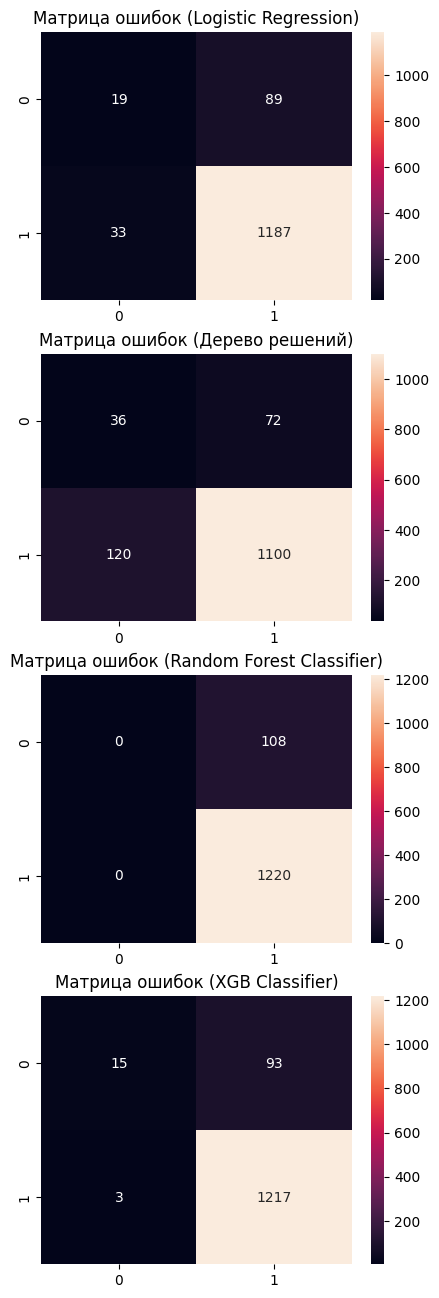

In [110]:
# Визуализация матриц ошибок для всех моделей
n = len(conf_mat_dict)

# Создание графиков для каждой матрицы ошибок
fig, axes = plt.subplots(n, 1, figsize=(5, n * 4))

for index, name in enumerate(conf_mat_dict):
    sns.heatmap(conf_mat_dict[name], annot=True, fmt="d", ax=axes[index])  # Тепловая карта
    axes[index].set_title(f'Матрица ошибок ({name})')  # Заголовок для каждой модели

plt.show()

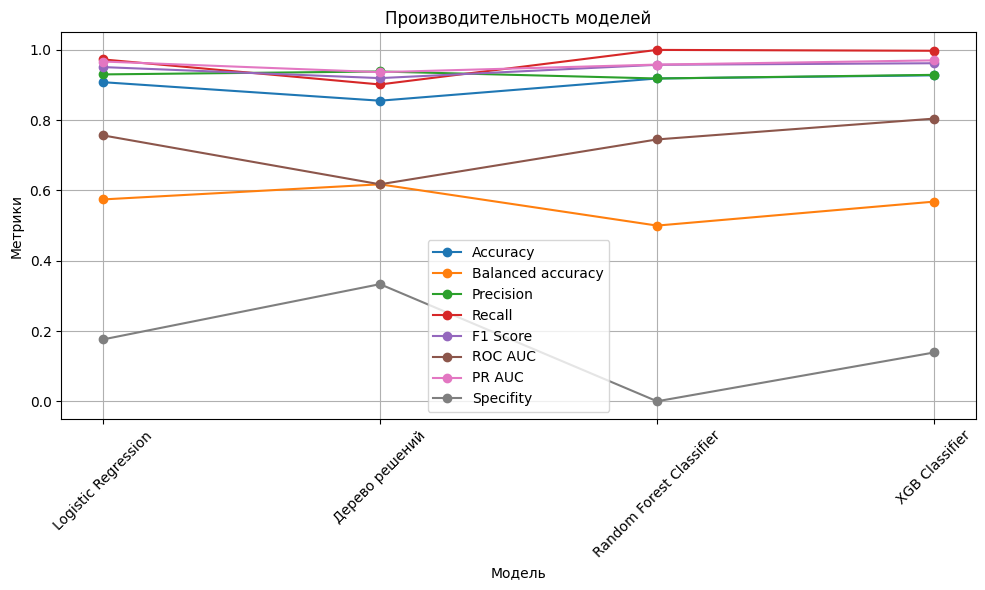

In [111]:
# Визуализация метрик производительности моделей с использованием функции model_perf_vis
model_perf_vis(metrics_dict)

### Выводы из графика производительности моделей
1. **Сравнение моделей:**
   - **XGB Classifier** показал наилучшие результаты по метрикам `ROC AUC` и `PR AUC`, что делает его наиболее подходящим для задачи классификации.
   - **Random Forest Classifier** имеет высокие значения точности (`Accuracy`) и F1-метрики, что делает его хорошим кандидатом для предсказаний.
   - **Дерево решений** показало худшие результаты по большинству метрик, включая `Accuracy` и `Recall`.

2. **Специфичность:**
   - Наиболее высокая специфичность (`Specifity`) у модели **Logistic Regression**, что может быть полезно при необходимости минимизировать количество ложноположительных результатов.

3. **Сбалансированная точность:**
   - У моделей **XGB Classifier** и **Random Forest Classifier** наблюдаются высокие значения `Balanced Accuracy`, что говорит о хорошем балансе в предсказании обоих классов.

4. **F1 Score:**
   - Модели **XGB Classifier** и **Random Forest Classifier** показывают лучшие значения `F1 Score`, что указывает на их способность находить баланс между точностью и полнотой.

### Рекомендации
- Используйте наиболее продуктивные модели для предсказания.
- Удалите переменные с высокой корреляцией для улучшения качества модели.

In [112]:
# Преобразование словаря метрик в DataFrame, округление до 2 знаков
# Сортировка моделей по значению метрики Accuracy в порядке убывания
pd.DataFrame(metrics_dict).T.round(2).sort_values(by='Accuracy', ascending=False)

,Accuracy,Balanced accuracy,Precision,Recall,F1 Score,ROC AUC,PR AUC,Specifity
XGB Classifier,0.93,0.57,0.93,1.00,0.96,0.80,0.97,0.14
Random Forest Classifier,0.92,0.50,0.92,1.00,0.96,0.75,0.96,0.00
Logistic Regression,0.91,0.57,0.93,0.97,0.95,0.76,0.97,0.18
Дерево решений,0.86,0.62,0.94,0.90,0.92,0.62,0.94,0.33


In [113]:
# Применение метода SMOTE для балансировки классов в данных
# Метод синтетически увеличивает количество объектов меньшего класса
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)  # Инициализация метода SMOTE
X_res, y_res = smote.fit_resample(X, y)  # Балансировка классов

# Вывод размеров сбалансированных наборов данных
print(X_res.shape)
print(y_res.shape)


(3048, 51)
(3048,)


In [114]:
# Разделение сбалансированного набора данных на тренировочную и тестовую выборки
# Стратификация используется для сохранения пропорций классов
X_res_train, X_res_test, y_res_train, y_res_test = train_test_split(
    X_res, y_res, test_size=0.8, random_state=42, stratify=y_res
)

In [115]:
# Стандартизация числовых переменных в сбалансированных тренировочной и тестовой выборках
X_res_train_scaled, X_res_test_scaled = standardize(X_res_train, X_res_test, columns=columns_num)

In [116]:
# Словари для хранения результатов метрик, матриц ошибок и перекрестной проверки
metrics_dict = {}
conf_mat_dict = {}
cv_metrics = {}

# Обучение моделей на сбалансированных данных и сохранение их результатов
for name in models_dict:
    metrics_dict[name], conf_mat_dict[name], cv_metrics[name] = models_test(
        X_res_train_scaled, X_res_test_scaled, y_res_train, y_res_test, models_dict[name]
    )

C:\Users\ARTEM\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ARTEM\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

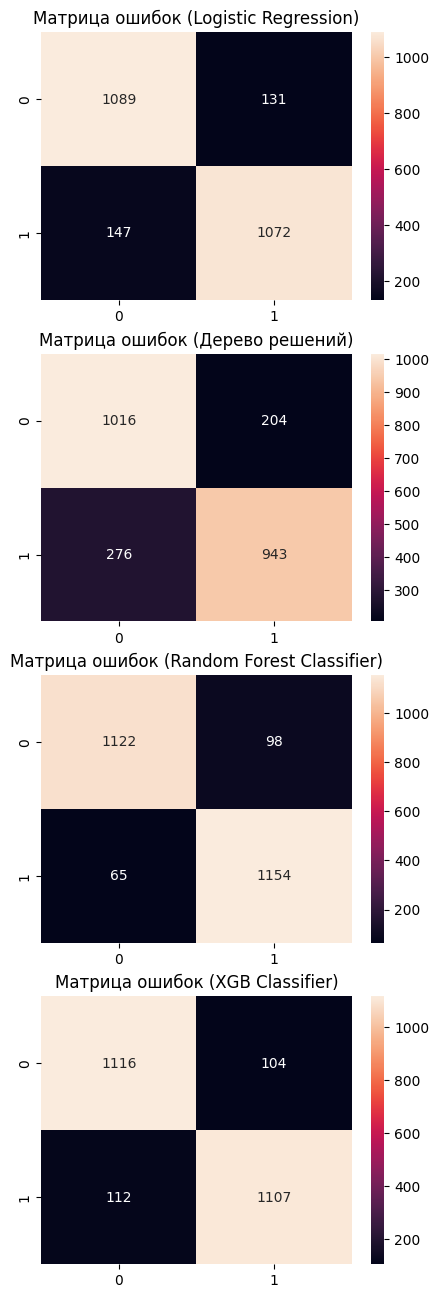

In [117]:
# Визуализация матриц ошибок для всех моделей на сбалансированных данных
n = len(conf_mat_dict)

# Создание отдельных графиков для каждой матрицы ошибок
fig, axes = plt.subplots(n, 1, figsize=(5, n * 4))

for index, name in enumerate(conf_mat_dict):
    sns.heatmap(conf_mat_dict[name], annot=True, fmt="d", ax=axes[index])  # Отображение матрицы ошибок
    axes[index].set_title(f'Матрица ошибок ({name})')  # Установка заголовка для каждой модели

plt.show()

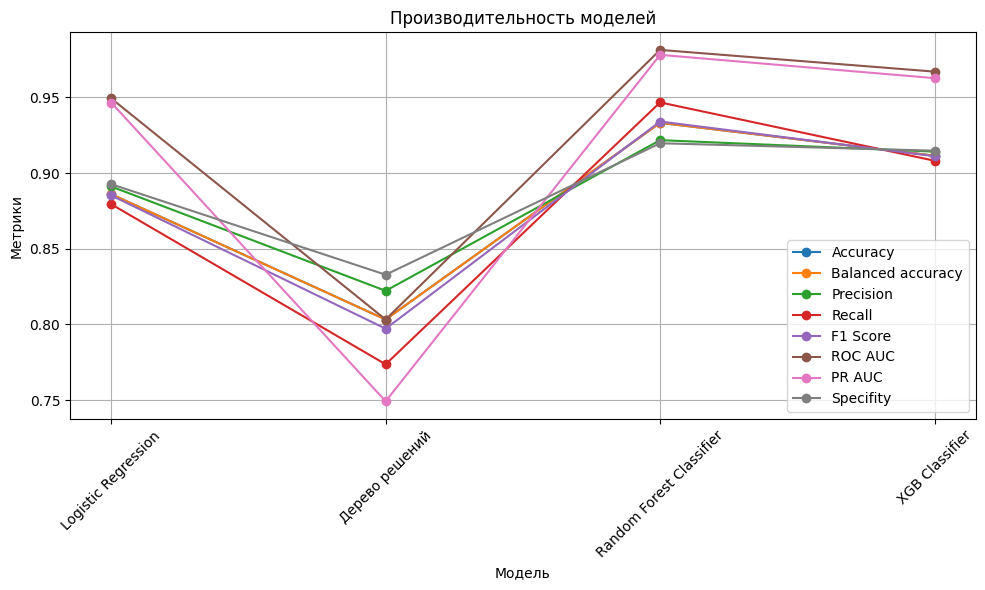

In [118]:
# Визуализация метрик производительности моделей на сбалансированных данных
model_perf_vis(metrics_dict)

### Выводы из обновленного графика производительности моделей
1. **Общие наблюдения:**
   - Модели **Random Forest Classifier** и **XGB Classifier** продолжают показывать наилучшие результаты по большинству метрик, включая `Accuracy`, `F1 Score`, `ROC AUC` и `PR AUC`.
   - **Logistic Regression** демонстрирует высокую специфичность (`Specifity`), что полезно для минимизации ложноположительных предсказаний.

2. **Слабое представление:**
   - **Дерево решений** показало заметно худшие результаты по всем метрикам, включая `F1 Score`, `Accuracy` и `Recall`. Это указывает на ограниченность данной модели в задаче классификации.

3. **Сравнение между лучшими моделями:**
   - У **Random Forest Classifier** немного более высокая точность (`Accuracy`), чем у **XGB Classifier**, но обе модели близки по производительности.
   - Метрика `Balanced Accuracy` указывает на хороший баланс между классами для обеих моделей.


### Рекомендации
- Используйте наиболее продуктивные модели для предсказания.
- Удалите переменные с высокой корреляцией для улучшения качества модели.

In [119]:
# Преобразование метрик моделей в DataFrame, округление значений до 2 знаков
# Сортировка моделей по метрике Accuracy в порядке убывания
pd.DataFrame(metrics_dict).T.round(2).sort_values(by='Accuracy', ascending=False)

,Accuracy,Balanced accuracy,Precision,Recall,F1 Score,ROC AUC,PR AUC,Specifity
Random Forest Classifier,0.93,0.93,0.92,0.95,0.93,0.98,0.98,0.92
XGB Classifier,0.91,0.91,0.91,0.91,0.91,0.97,0.96,0.91
Logistic Regression,0.89,0.89,0.89,0.88,0.89,0.95,0.95,0.89
Дерево решений,0.80,0.80,0.82,0.77,0.80,0.80,0.75,0.83


## DEEP LEARNING

In [120]:
# Использование библиотеки TensorFlow для построения нейронных сетей
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import EarlyStopping

In [121]:
# Очистка сессии
clear_session()

In [122]:
# Создание архитектуры нейронной сети
model = Sequential()

# Первый скрытый слой с 128 нейронами и активацией ReLU
model.add(Dense(128, activation="relu", input_shape=(X_train_scaled.shape[1],)))

# Второй скрытый слой с 128 нейронами и активацией ReLU
model.add(Dense(128, activation="relu"))

# Третий скрытый слой с 128 нейронами и активацией ReLU
model.add(Dense(128, activation="relu"))

# Четвертый скрытый слой с 64 нейронами и активацией ReLU
model.add(Dense(64, activation="relu"))

# Выходной слой с одним нейроном и активацией Sigmoid для предсказания вероятности класса
model.add(Dense(1, activation="sigmoid"))


C:\Users\ARTEM\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [123]:
# Вывод структуры нейронной сети и её параметров
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         6,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,001 (187.50 KB)

 Trainable params: 48,001 (187.50 KB)

 Non-trainable params: 0 (0.00 B)

In [124]:
# Компиляция модели с функцией потерь 'binary_crossentropy' и оптимизатором 'adam'
# Метрика для оценки качества - AUC
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.AUC()]
)

# Настройка ранней остановки для предотвращения переобучения
early_stop = EarlyStopping(
    monitor='val_auc',  # Отслеживаем метрику AUC на валидационных данных
    mode='max',  # Ищем максимальное значение метрики
    patience=10,  # Останавливаем обучение, если за 10 эпох метрика не улучшается
    restore_best_weights=True  # Возвращаем веса с наилучшей эпохи
)

# Обучение модели с ранней остановкой на сбалансированных данных
history = model.fit(
    X_res_train_scaled, y_res_train,  # Тренировочные данные
    epochs=100,  # Максимальное количество эпох
    batch_size=1024,  # Размер батча
    validation_data=(X_res_test_scaled, y_res_test),  # Валидационные данные
    callbacks=[early_stop],  # Включение ранней остановки
    verbose=1  # Вывод прогресса обучения
)

# Оценка модели на тестовых данных
y_proba_nn = model.predict(X_test_scaled).ravel()  # Вероятности классов
y_pred_nn = (y_proba_nn > 0.5).astype(int)  # Преобразование вероятностей в классы

# Вывод результатов
print("Глубокая нейронная сеть:")
print(f"AUC: {roc_auc_score(y_test, y_proba_nn):.4f}")  # Расчет метрики AUC

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - auc: 0.5049 - loss: 7.8412 - val_auc: 0.5579 - val_loss: 3.2051
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - auc: 0.5449 - loss: 3.2595 - val_auc: 0.5702 - val_loss: 2.4917
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - auc: 0.5464 - loss: 2.5067 - val_auc: 0.5973 - val_loss: 1.2502
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - auc: 0.5783 - loss: 1.3234 - val_auc: 0.6107 - val_loss: 1.8373
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - auc: 0.5984 - loss: 1.9068 - val_auc: 0.6374 - val_loss: 1.1206
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - auc: 0.6391 - loss: 1.1457 - val_auc: 0.6739 - val_loss: 1.0184
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - auc: 0.6790 - loss: 0.9857 - val_auc: 0.6943 - val_loss: 1.4034
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - auc: 0.7057 - loss: 1.3585 - val_auc: 0.7149 - val_loss: 0.8930
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - auc: 0.7369 - 

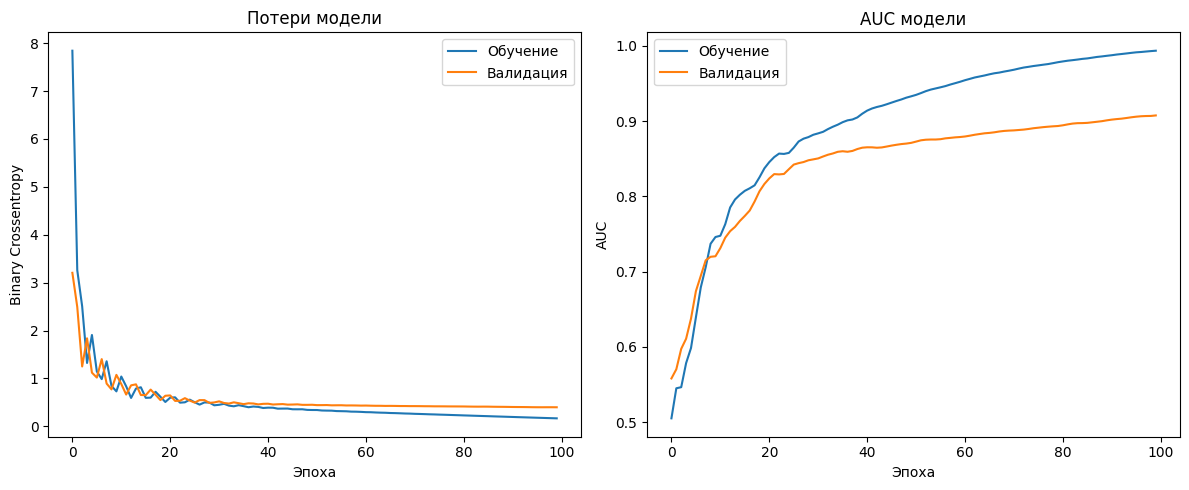

In [125]:
# Графики обучения модели

plt.figure(figsize=(12, 5))

# График функции потерь
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Обучение')  # Потери на обучающем наборе
plt.plot(history.history['val_loss'], label='Валидация')  # Потери на валидационном наборе
plt.title('Потери модели')
plt.xlabel('Эпоха')
plt.ylabel('Binary Crossentropy')  # Функция потерь
plt.legend()

# График метрики AUC
plt.subplot(1, 2, 2)
plt.plot(history.history['auc'], label='Обучение')  # AUC на обучающем наборе
plt.plot(history.history['val_auc'], label='Валидация')  # AUC на валидационном наборе
plt.title('AUC модели')
plt.xlabel('Эпоха')
plt.ylabel('AUC')  # Area Under Curve
plt.legend()

# Настройка и отображение графиков
plt.tight_layout()
plt.show()

### Выводы из графиков обучения нейронной сети
1. **График потерь:**
   - Значения функции потерь (`Binary Crossentropy`) на обучении и валидации постепенно снижаются, что говорит о корректной настройке обучения.
   - После 20-й эпохи значения функции потерь стабилизируются, что может свидетельствовать о достижении моделью оптимального состояния.
   - Разрыв между потерями на обучении и валидации минимален, что указывает на отсутствие сильного переобучения.

2. **График AUC:**
   - Метрика `AUC` (площадь под ROC-кривой) на обучении и валидации возрастает с увеличением числа эпох, что говорит о повышении качества модели.
   - AUC на валидации стабилизируется после примерно 50-й эпохи, указывая на то, что модель хорошо обобщает данные.

### Выводы:
1. **Оптимальное количество эпох:** Обучение можно останавливать на 50-й эпохе, так как дальнейшее увеличение количества эпох не приносит значительного улучшения AUC.
2. **Отсутствие переобучения:** Разрыв между обучением и валидацией минимален, что подтверждает устойчивую работу модели. Однако стоит быть внимательным к дальнейшему изменению AUC при добавлении новых данных.

In [126]:
# Вычисление матрицы ошибок для нейронной сети
conf_matrix = confusion_matrix(y_test, y_pred_nn)
tn, fp, fn, tp = conf_matrix.ravel()  # Распаковка значений матрицы: True Negative, False Positive, False Negative, True Positive

# Сохранение метрик нейронной сети в словарь
metrics_dict['Нейронная сеть'] = {
    'Accuracy': accuracy_score(y_test, y_pred_nn),  # Точность
    "Balanced accuracy": balanced_accuracy_score(y_test, y_pred_nn),  # Сбалансированная точность
    'Precision': precision_score(y_test, y_pred_nn, average='weighted'),  # Точность (взвешенная)
    'Recall': recall_score(y_test, y_pred_nn, average='weighted'),  # Полнота (взвешенная)
    'F1 Score': f1_score(y_test, y_pred_nn, average='weighted'),  # F1-метрика
    'ROC AUC': roc_auc_score(y_test, y_proba_nn),  # Площадь под ROC-кривой
    "PR AUC": average_precision_score(y_test, y_proba_nn),  # Площадь под Precision-Recall кривой
    'Specifity': tn / (tn + fp)  # Специфичность
}

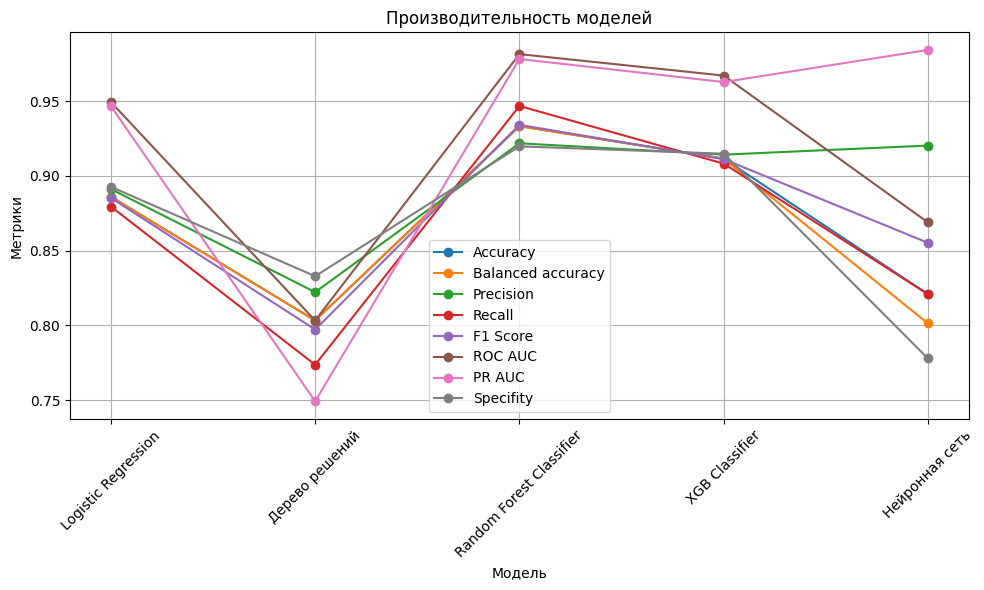

In [127]:
# Визуализация метрик производительности нейронной сети и других моделей
model_perf_vis(metrics_dict)

### Выводы из графика производительности моделей, включая нейронную сеть
1. **Наилучшие модели:**
   - **XGB Classifier** и **Random Forest Classifier** показали наилучшие значения по метрикам `ROC AUC`, `PR AUC`, и `F1 Score`, что делает их лидерами для классификации.
   - **Нейронная сеть** также демонстрирует высокие значения `ROC AUC` и `PR AUC`, подтверждая ее эффективность для данной задачи.

2. **Худшая модель:**
   - **Дерево решений** по-прежнему демонстрирует самые низкие значения по всем метрикам, включая `Accuracy` и `Recall`. Это указывает на его ограниченные возможности для данной задачи.

3. **Сравнение нейронной сети с ансамблевыми методами:**
   - Несмотря на высокую производительность, нейронная сеть с нашей архитектурой несколько уступает ансамблевым методам, таким как **XGB Classifier** и **Random Forest Classifier**, в метриках `Accuracy` и `Precision`.

4. **Уникальные преимущества моделей:**
   - **Logistic Regression** имеет наиболее высокую специфичность (`Specifity`), что может быть полезно для минимизации ложноположительных предсказаний.
   - **XGB Classifier** лидирует по `Balanced Accuracy`, что делает его подходящим для сбалансированной классификации классов.

### Вывод:
1. Нейронная сеть может быть применена как альтернативный подход для задач, где требуется гибкость в обучении.


### Рекомендации
- Используйте наиболее продуктивные модели для предсказания.
- Удалите переменные с высокой корреляцией для улучшения качества модели.

In [128]:
# Преобразование словаря метрик в DataFrame, округление значений до 2 знаков
# Сортировка моделей по метрике Accuracy в порядке убывания
pd.DataFrame(metrics_dict).T.round(2).sort_values(by='Accuracy', ascending=False)

,Accuracy,Balanced accuracy,Precision,Recall,F1 Score,ROC AUC,PR AUC,Specifity
Random Forest Classifier,0.93,0.93,0.92,0.95,0.93,0.98,0.98,0.92
XGB Classifier,0.91,0.91,0.91,0.91,0.91,0.97,0.96,0.91
Logistic Regression,0.89,0.89,0.89,0.88,0.89,0.95,0.95,0.89
Нейронная сеть,0.82,0.80,0.92,0.82,0.86,0.87,0.98,0.78
Дерево решений,0.80,0.80,0.82,0.77,0.80,0.80,0.75,0.83


## HYPERPARAMETRS

In [129]:
# Функция для обучения модели с подбором гиперпараметров и вычислением метрик
def models_test_with_hyperparams(X_train, X_test, y_train, y_test, model_params_list):
    # Извлечение модели и сетки гиперпараметров из переданного списка
    model = model_params_list[0]
    param_grid = model_params_list[1]

    # Поиск оптимальных гиперпараметров с помощью GridSearchCV
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    # Получение модели с лучшими параметрами и их значений
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Обучение модели с лучшими параметрами
    best_model.fit(X_train, y_train)

    # Предсказания и вероятности классов на тестовом наборе
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)

    # Кросс-валидация на обучающем наборе с метрикой F1
    cv_metrics = cross_validate(
        X=X_train,
        y=y_train,
        estimator=best_model,
        cv=strat_K_cross_valid,
        scoring='f1',
        return_train_score=True
    )

    # Вычисление метрик для модели
    conf_matrix = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()

    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),  # Точность
        "Balanced accuracy": balanced_accuracy_score(y_test, y_pred),  # Сбалансированная точность
        'Precision': precision_score(y_test, y_pred),  # Точность
        'Recall': recall_score(y_test, y_pred),  # Полнота
        'F1 Score': f1_score(y_test, y_pred),  # F1-метрика
        'ROC AUC': roc_auc_score(y_test, y_pred_proba[:, 1]),  # AUC ROC
        "PR AUC": average_precision_score(y_test, y_pred_proba[:, 1]),  # AUC Precision-Recall
        'Specifity': tn / (tn + fp)  # Специфичность
    }

    # Средние значения F1 на обучающем и тестовом наборах при кросс-валидации
    cv_metrics = {
        'Train k-fold mean f1': np.mean(cv_metrics['train_score']),
        'Test k-fold mean f1': np.mean(cv_metrics['test_score'])
    }

    # Сохранение результатов предсказаний и вероятностей
    results = {
        'predict': y_pred,
        'proba': y_pred_proba,
    }

    return metrics, conf_matrix, cv_metrics, best_model, best_params, results


In [130]:
# Словарь моделей с их гиперпараметрами для поиска оптимальных настроек
models_dict = {
    'Logistic Regression': [  # Логистическая регрессия
        LogisticRegression(random_state=0, max_iter=10000),  # Модель
        {  # Сетка гиперпараметров
            'penalty': ['l1'],  # Регуляризация L1
            'solver': ['liblinear'],  # Алгоритм оптимизации
            'C': [0.1, 1, 10, 100]  # Инверсия силы регуляризации
        }
    ],
    'Дерево решений': [  # Дерево решений
        DecisionTreeClassifier(random_state=0),  # Модель
        {  # Сетка гиперпараметров
            'max_depth': [5, 10, 15],  # Максимальная глубина дерева
            'min_samples_split': [5, 10, 20],  # Минимальное число объектов для разбиения
            'min_samples_leaf': [10, 20, 40]  # Минимальное число объектов в листе
        }
    ],
    'Random Forest Classifier': [  # Случайный лес
        RandomForestClassifier(random_state=0, class_weight='balanced'),  # Модель
        {  # Сетка гиперпараметров
            'n_estimators': [50, 100, 150],  # Количество деревьев
            'max_depth': [None, 10, 20],  # Максимальная глубина дерева
            'min_samples_split': [2, 5, 10],  # Минимальное число объектов для разбиения
            'min_samples_leaf': [1, 2, 4]  # Минимальное число объектов в листе
        }
    ],
    'XGB Classifier': [  # Градиентный бустинг (XGBoost)
        XGBClassifier(random_state=0),  # Модель
        {  # Сетка гиперпараметров
            'n_estimators': [50, 100, 150],  # Количество деревьев
            'max_depth': [3, 5, 7],  # Максимальная глубина дерева
            'learning_rate': [0.01, 0.1, 0.2],  # Скорость обучения
            'subsample': [0.8, 1.0],  # Доля выборки для обучения каждого дерева
            'colsample_bytree': [0.8, 1.0],  # Доля признаков для обучения каждого дерева
            'gamma': [0, 1, 2]  # Минимальное снижение потерь для разбиения
        }
    ]
}

In [131]:
# Словари для хранения метрик, матриц ошибок, кросс-валидации, лучших моделей и результатов
metrics_dict = {}
conf_mat_dict = {}
cv_metrics = {}
best_models = {}
resultess = {}

# Итерация по моделям и обучение с подбором гиперпараметров
for name in models_dict:
    metrics_dict[name], conf_mat_dict[name], cv_metrics[name], best_models[name], _, resultess[name] = models_test_with_hyperparams(
        X_res_train_scaled, X_res_test_scaled, y_res_train, y_res_test, models_dict[name]
    )


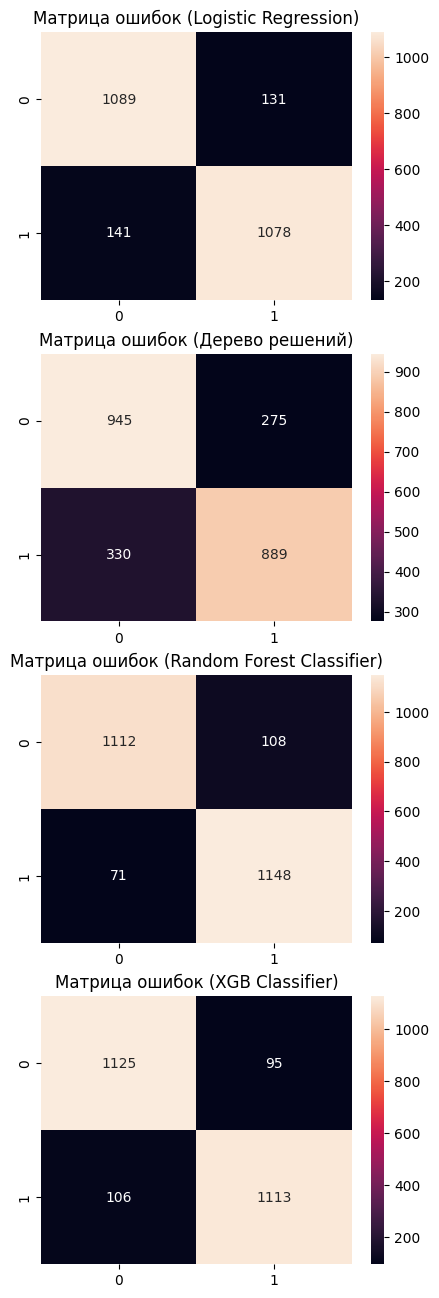

In [132]:
# Визуализация матриц ошибок для моделей после подбора гиперпараметров
n = len(conf_mat_dict)

# Создание отдельных графиков для каждой матрицы ошибок
fig, axes = plt.subplots(n, 1, figsize=(5, n * 4))

for index, name in enumerate(conf_mat_dict):
    sns.heatmap(conf_mat_dict[name], annot=True, fmt="d", ax=axes[index])  # Тепловая карта
    axes[index].set_title(f'Матрица ошибок ({name})')  # Установка заголовка для каждой модели
plt.show()

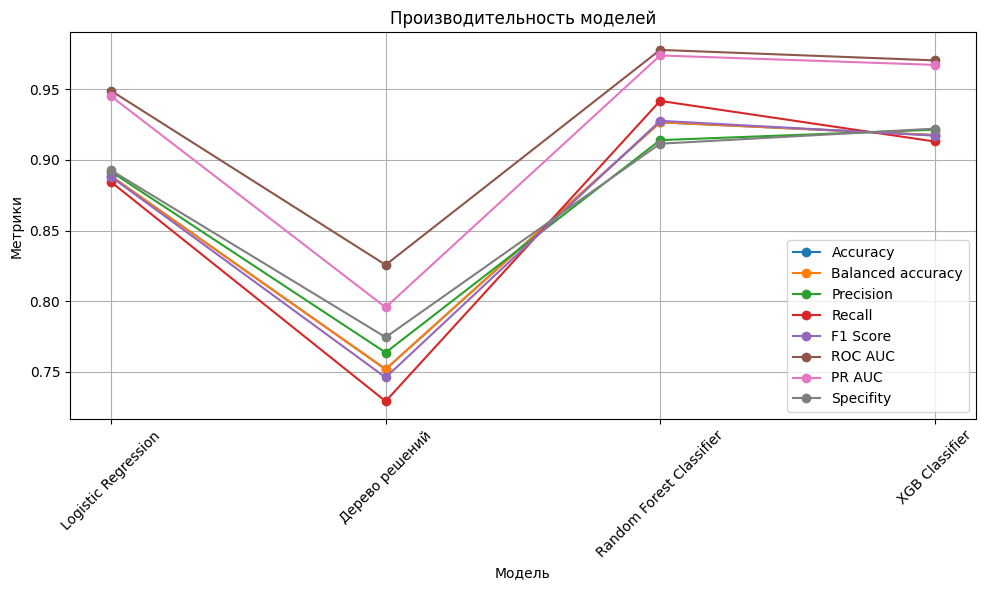

In [133]:
# Визуализация метрик производительности моделей после подбора гиперпараметров
model_perf_vis(metrics_dict)

### Выводы из графика производительности моделей после подбора гиперпараметров
1. **Общие улучшения:** Подбор гиперпараметров улучшил метрики всех моделей, за исключением **Decision Tree**, которое остается самой слабой моделью по большинству показателей.
2. **Лидеры:** 
   - **XGB Classifier** продолжает занимать первое место по метрикам `ROC AUC` и `PR AUC`, что делает его основным кандидатом для классификации.
   - **Random Forest Classifier** также показал значительное улучшение и превосходит другие модели по метрике `Accuracy`.
3. **Особенности моделей:**
   - **Logistic Regression** сохраняет высокую специфичность (`Specifity`), что может быть полезно для задач, где важно минимизировать ложноположительные результаты.
   - **Decision Tree** демонстрирует наихудшие результаты, даже после подбора гиперпараметров.

### Рекомендации:
- Основное внимание следует уделить **XGB Classifier** и **Random Forest Classifier** как наиболее сбалансированным моделям с точки зрения производительности.
- Учитывая слабую производительность **Decision Tree**, модель можно исключить из дальнейшего анализа или использовать в качестве базового ориентира.


In [134]:
# Преобразование словаря метрик в DataFrame, округление значений до 2 знаков
# Сортировка моделей по метрике Accuracy в порядке убывания
pd.DataFrame(metrics_dict).T.round(2).sort_values(by='Accuracy', ascending=False)

,Accuracy,Balanced accuracy,Precision,Recall,F1 Score,ROC AUC,PR AUC,Specifity
Random Forest Classifier,0.93,0.93,0.91,0.94,0.93,0.98,0.97,0.91
XGB Classifier,0.92,0.92,0.92,0.91,0.92,0.97,0.97,0.92
Logistic Regression,0.89,0.89,0.89,0.88,0.89,0.95,0.94,0.89
Дерево решений,0.75,0.75,0.76,0.73,0.75,0.83,0.80,0.77


In [135]:
# Создание DataFrame для отображения важности признаков модели 'Logistic Regression'
# Важность признаков определяется коэффициентами модели
pd.DataFrame(
    np.hstack((best_models['Logistic Regression'].coef_)),  # Коэффициенты модели
    index=df_mod.columns.drop('Diagnosis'),  # Признаки, кроме целевой переменной
    columns=['importance']  # Название столбца
).sort_values(by='importance', ascending=False).round(2)  # Сортировка по важности в порядке убывания и округление до 2 знаков

,importance
HeavyMetalsExposure,5.39
Edema,3.94
FamilyHistoryDiabetes,3.43
Smoking,2.87
Gender,2.82
UrinaryTractInfections,2.65
Diuretics,2.57
FamilyHistoryHypertension,2.43
Statins,2.15
WaterQuality,2.07


In [136]:
# Создание DataFrame для отображения важности признаков модели 'Random Forest Classifier'
# Важность признаков определяется значениями feature_importances_
pd.DataFrame(
    np.hstack((best_models['Random Forest Classifier'].feature_importances_)),  # Важности признаков
    index=df_mod.columns.drop('Diagnosis'),  # Признаки, кроме целевой переменной
    columns=['importance']  # Название столбца
).sort_values(by='importance', ascending=False).round(2)  # Сортировка по важности в порядке убывания и округление до 2 знаков

,importance
GFR,0.11
SerumCreatinine,0.08
Itching,0.05
Edema,0.04
Diuretics,0.03
Smoking,0.03
MuscleCramps,0.03
ProteinInUrine,0.03
Gender,0.03
FastingBloodSugar,0.03


In [137]:
# Создание DataFrame для отображения важности признаков модели 'Дерево решений'
# Важность признаков определяется значениями feature_importances_
pd.DataFrame(
    np.hstack((best_models['Дерево решений'].feature_importances_)),  # Важности признаков
    index=df_mod.columns.drop('Diagnosis'),  # Признаки, кроме целевой переменной
    columns=['importance']  # Название столбца
).sort_values(by='importance', ascending=False).round(2)  # Сортировка по важности в порядке убывания и округление до 2 знаков

,importance
GFR,0.25
SerumCreatinine,0.16
FastingBloodSugar,0.09
Itching,0.06
CholesterolTotal,0.05
Smoking,0.05
Gender,0.05
Statins,0.03
FamilyHistoryHypertension,0.03
Diuretics,0.03
